In [4]:
# IoT Plant Growth Prediction Model
# Based on Advanced_IoT_Dataset.csv from Tikrit University Research

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

In [5]:
class PlantGrowthPredictor:
    """
    Advanced IoT Plant Growth Prediction Model
    Predicts plant class based on growth parameters from IoT greenhouse data
    """

    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        # Corrected feature column names based on dataset info
        self.feature_columns = [
            ' Average  of chlorophyll in the plant (ACHP)',   # Average chlorophyll in plant
            ' Plant height rate (PHR)',    # Plant height rate
            'Average wet weight of the growth vegetative (AWWGV)',  # Average wet weight of growth vegetative
            'Average leaf area of the plant (ALAP)',   # Average leaf area of plant
            'Average number of plant leaves (ANPL)',   # Average number of plant leaves
            'Average root diameter (ARD)',    # Average root diameter
            ' Average dry weight of the root (ADWR)',   # Average dry weight of root
            ' Percentage of dry matter for vegetative growth (PDMVG)',  # Percentage of dry matter for vegetative growth
            'Average root length (ARL)',    # Average root length
            'Average wet weight of the root (AWWR)',   # Average wet weight of root
            ' Average dry weight of vegetative plants (ADWV)',   # Average dry weight of vegetative plants
            'Percentage of dry matter for root growth (PDMRG)'   # Percentage of dry matter for root growth
        ]

    def load_and_preprocess_data(self, file_path):
        """Load and preprocess the IoT dataset"""
        print("Loading IoT Plant Growth Dataset...")

        # Load dataset
        df = pd.read_csv("/content/Advanced_IoT_Dataset.csv")
        print(f"Dataset shape: {df.shape}")

        # Display basic info
        print("\nDataset Info:")
        print(df.info())

        # Check for missing values
        print("\nMissing values:")
        print(df.isnull().sum())

        # Basic statistics
        print("\nDataset statistics:")
        print(df.describe())

        # Check class distribution
        print("\nClass distribution:")
        print(df['Class'].value_counts())

        return df

    def feature_analysis(self, df):
        """Analyze features and their relationships"""
        print("\n" + "="*50)
        print("FEATURE ANALYSIS")
        print("="*50)

        # Correlation matrix
        correlation_matrix = df[self.feature_columns].corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()

        # Feature importance using Random Forest
        X = df[self.feature_columns]
        y = df['Class']

        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)

        feature_importance = pd.DataFrame({
            'feature': self.feature_columns,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nFeature Importance (Random Forest):")
        print(feature_importance)

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance, x='importance', y='feature')
        plt.title('Feature Importance for Plant Classification')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

        return feature_importance

    def prepare_data(self, df):
        """Prepare data for machine learning"""
        print("\nPreparing data for machine learning...")

        # Extract features and target
        X = df[self.feature_columns].copy()
        y = df['Class'].copy()

        # Handle any missing values (if present)
        X = X.fillna(X.mean())

        # Encode target variable if it's categorical
        y_encoded = self.label_encoder.fit_transform(y)

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        print(f"Training set shape: {X_train_scaled.shape}")
        print(f"Test set shape: {X_test_scaled.shape}")

        return X_train_scaled, X_test_scaled, y_train, y_test, X_train, X_test

    def train_models(self, X_train, y_train):
        """Train multiple models and select the best one"""
        print("\n" + "="*50)
        print("MODEL TRAINING AND COMPARISON")
        print("="*50)

        # Define models to compare
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'SVM': SVC(kernel='rbf', random_state=42)
        }

        # Cross-validation scores
        cv_scores = {}

        for name, model in models.items():
            scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
            cv_scores[name] = scores
            print(f"{name} CV Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

        # Select best model based on CV scores
        best_model_name = max(cv_scores.keys(),
                             key=lambda x: cv_scores[x].mean())

        print(f"\nBest model: {best_model_name}")

        # Train the best model
        self.model = models[best_model_name]
        self.model.fit(X_train, y_train)

        return best_model_name, cv_scores

    def hyperparameter_tuning(self, X_train, y_train):
        """Perform hyperparameter tuning for the best model"""
        print("\nPerforming hyperparameter tuning...")

        if isinstance(self.model, RandomForestClassifier):
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        elif isinstance(self.model, GradientBoostingClassifier):
            param_grid = {
                'n_estimators': [100, 200],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1, 0.2],
                'subsample': [0.8, 0.9, 1.0]
            }
        else:  # SVM
            param_grid = {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                'kernel': ['rbf', 'poly']
            }

        grid_search = GridSearchCV(
            estimator=self.model,
            param_grid=param_grid,
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_train, y_train)

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        self.model = grid_search.best_estimator_

        return grid_search.best_params_

    def evaluate_model(self, X_test, y_test):
        """Evaluate the trained model"""
        print("\n" + "="*50)
        print("MODEL EVALUATION")
        print("="*50)

        # Make predictions
        y_pred = self.model.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Test Accuracy: {accuracy:.4f}")

        # Classification report
        class_names = self.label_encoder.classes_
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred,
                                  target_names=class_names))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

        return accuracy, y_pred

    def predict_single_sample(self, sample_data):
        """Predict class for a single sample"""
        if self.model is None:
            raise ValueError("Model not trained yet!")

        # Ensure sample_data is in the correct format
        if isinstance(sample_data, dict):
            sample_array = np.array([sample_data[col] for col in self.feature_columns]).reshape(1, -1)
        else:
            sample_array = np.array(sample_data).reshape(1, -1)

        # Scale the sample
        sample_scaled = self.scaler.transform(sample_array)

        # Make prediction
        prediction = self.model.predict(sample_scaled)[0]
        probability = self.model.predict_proba(sample_scaled)[0]

        # Convert back to original class name
        predicted_class = self.label_encoder.inverse_transform([prediction])[0]

        return predicted_class, probability

    def save_model(self, filepath):
        """Save the trained model and preprocessing objects"""
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'label_encoder': self.label_encoder,
            'feature_columns': self.feature_columns
        }
        joblib.dump(model_data, filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """Load a trained model and preprocessing objects"""
        model_data = joblib.load(filepath)
        self.model = model_data['model']
        self.scaler = model_data['scaler']
        self.label_encoder = model_data['label_encoder']
        self.feature_columns = model_data['feature_columns']
        print(f"Model loaded from {filepath}")

In [6]:
# Example usage and real-world implementation
def main():
    """Main function to demonstrate the complete workflow"""

    # Initialize the predictor
    predictor = PlantGrowthPredictor()

    # Load and preprocess data
    df = predictor.load_and_preprocess_data('Advanced_IoT_Dataset.csv')

    # Perform feature analysis
    feature_importance = predictor.feature_analysis(df)

    # Prepare data for machine learning
    X_train, X_test, y_train, y_test, X_train_orig, X_test_orig = predictor.prepare_data(df)

    # Train models and select the best one
    best_model, cv_scores = predictor.train_models(X_train, y_train)

    # Perform hyperparameter tuning
    best_params = predictor.hyperparameter_tuning(X_train, y_train)

    # Evaluate the model
    accuracy, predictions = predictor.evaluate_model(X_test, y_test)

    # Save the model for real-world deployment
    predictor.save_model('plant_growth_model.pkl')

    # Example of real-world prediction
    print("\n" + "="*50)
    print("REAL-WORLD PREDICTION EXAMPLE")
    print("="*50)

    # Sample IoT sensor data (you would get this from your IoT system)
    sample_iot_data = {
        ' Average  of chlorophyll in the plant (ACHP)': 45.2,    # Chlorophyll content
        ' Plant height rate (PHR)': 12.5,     # Plant height rate
        'Average wet weight of the growth vegetative (AWWGV)': 8.3,    # Wet weight vegetative
        'Average leaf area of the plant (ALAP)': 150.7,   # Leaf area
        'Average number of plant leaves (ANPL)': 25.0,    # Number of leaves
        'Average root diameter (ARD)': 2.8,      # Root diameter
        ' Average dry weight of the root (ADWR)': 1.2,     # Dry weight root
        ' Percentage of dry matter for vegetative growth (PDMVG)': 18.5,   # Dry matter vegetative %
        'Average root length (ARL)': 15.3,     # Root length
        'Average wet weight of the root (AWWR)': 3.1,     # Wet weight root
        ' Average dry weight of vegetative plants (ADWV)': 4.7,     # Dry weight vegetative
        'Percentage of dry matter for root growth (PDMRG)': 22.1    # Dry matter root %
    }

    predicted_class, probabilities = predictor.predict_single_sample(sample_iot_data)

    print(f"Predicted Plant Class: {predicted_class}")
    print(f"Prediction Probabilities: {probabilities}")

    return predictor

In [7]:
# Real-world deployment class
class IoTPlantMonitor:
    """
    Class for real-world IoT implementation
    Integrates with IoT sensors to make real-time predictions
    """

    def __init__(self, model_path):
        self.predictor = PlantGrowthPredictor()
        self.predictor.load_model(model_path)

    def process_sensor_data(self, sensor_data):
        """Process real-time sensor data from IoT devices"""
        try:
            # Validate sensor data
            required_features = self.predictor.feature_columns
            if not all(feature in sensor_data for feature in required_features):
                missing = [f for f in required_features if f not in sensor_data]
                raise ValueError(f"Missing sensor data for: {missing}")

            # Make prediction
            predicted_class, probabilities = self.predictor.predict_single_sample(sensor_data)

            # Create response
            response = {
                'timestamp': pd.Timestamp.now(),
                'sensor_data': sensor_data,
                'predicted_class': predicted_class,
                'confidence': float(max(probabilities)),
                'all_probabilities': dict(zip(self.predictor.label_encoder.classes_,
                                            probabilities))
            }

            return response

        except Exception as e:
            return {'error': str(e), 'timestamp': pd.Timestamp.now()}

    def batch_process(self, sensor_data_list):
        """Process multiple sensor readings in batch"""
        results = []
        for sensor_data in sensor_data_list:
            result = self.process_sensor_data(sensor_data)
            results.append(result)
        return results

Loading IoT Plant Growth Dataset...
Dataset shape: (30000, 14)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Random                                                   30000 non-null  object 
 1    Average  of chlorophyll in the plant (ACHP)             30000 non-null  float64
 2    Plant height rate (PHR)                                 30000 non-null  float64
 3   Average wet weight of the growth vegetative (AWWGV)      30000 non-null  float64
 4   Average leaf area of the plant (ALAP)                    30000 non-null  float64
 5   Average number of plant leaves (ANPL)                    30000 non-null  float64
 6   Average root diameter (ARD)                              30000 non-null  float64
 7    Average dry weight of the root (A

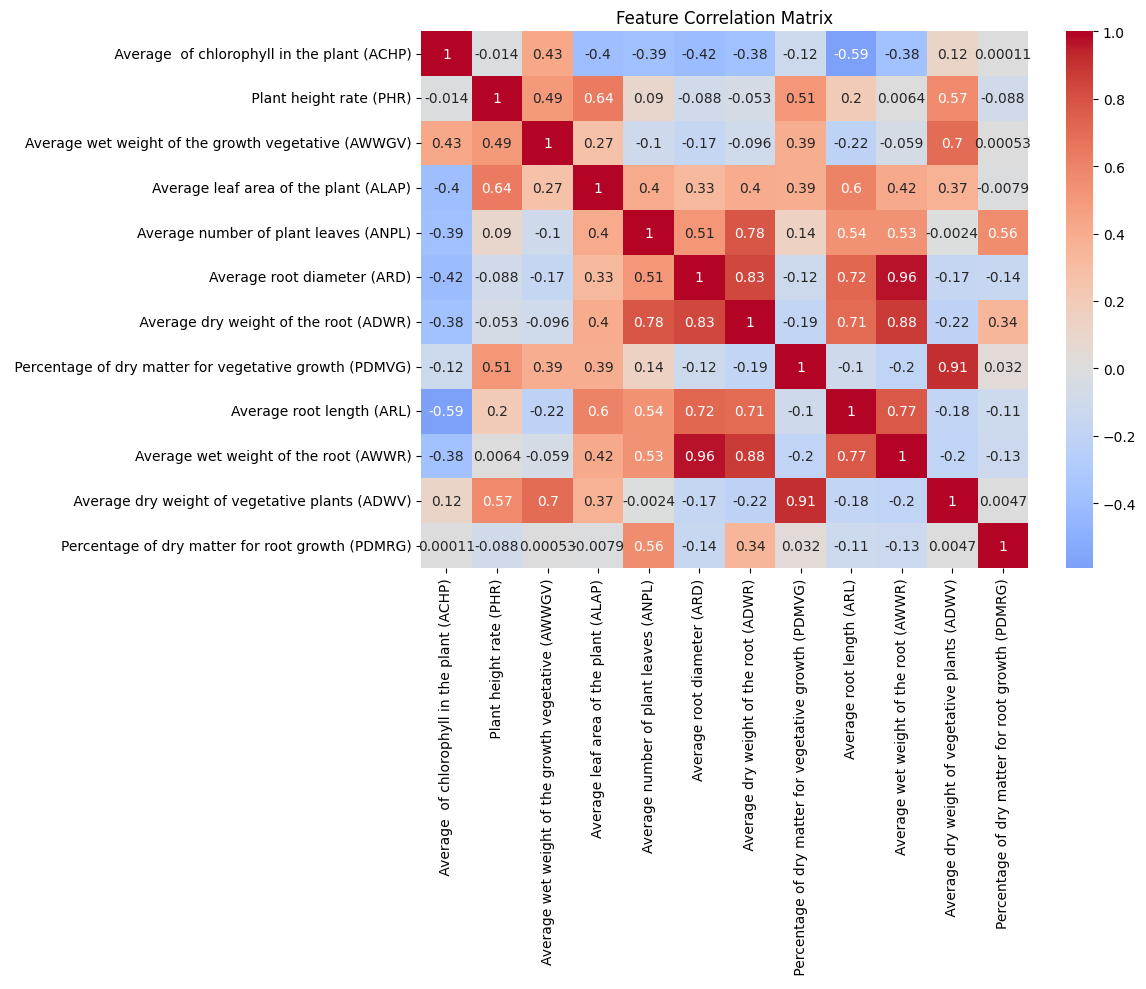


Feature Importance (Random Forest):
                                              feature  importance
1                             Plant height rate (PHR)    0.197073
5                         Average root diameter (ARD)    0.123884
3               Average leaf area of the plant (ALAP)    0.123749
7    Percentage of dry matter for vegetative growt...    0.115221
9               Average wet weight of the root (AWWR)    0.111933
8                           Average root length (ARL)    0.096282
0         Average  of chlorophyll in the plant (ACHP)    0.065073
6               Average dry weight of the root (ADWR)    0.053571
10     Average dry weight of vegetative plants (ADWV)    0.049467
2   Average wet weight of the growth vegetative (A...    0.030069
11   Percentage of dry matter for root growth (PDMRG)    0.019850
4               Average number of plant leaves (ANPL)    0.013828


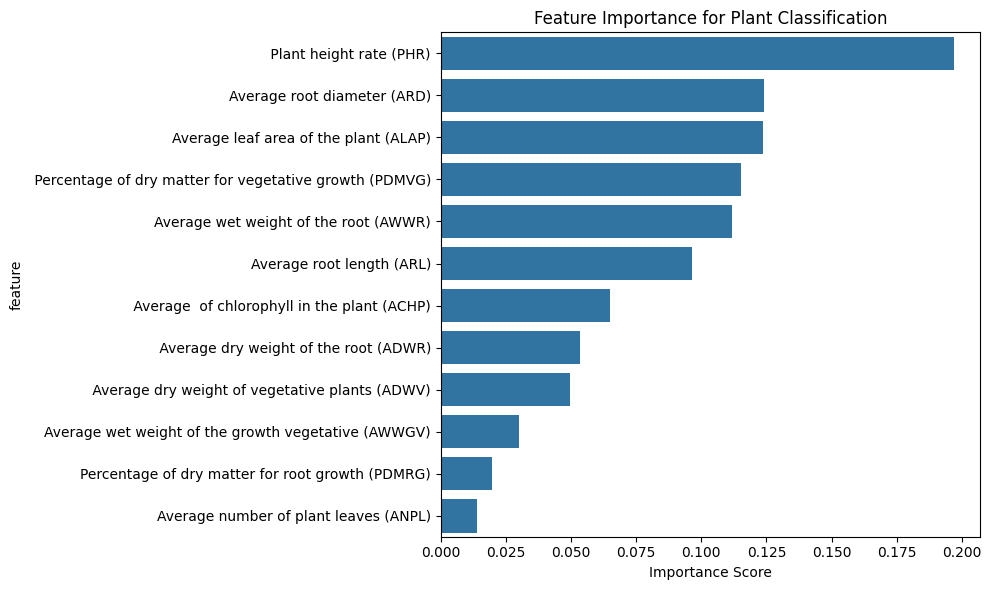


Preparing data for machine learning...
Training set shape: (24000, 12)
Test set shape: (6000, 12)

MODEL TRAINING AND COMPARISON
Random Forest CV Accuracy: 1.0000 (+/- 0.0000)
Gradient Boosting CV Accuracy: 1.0000 (+/- 0.0002)
SVM CV Accuracy: 1.0000 (+/- 0.0000)

Best model: Random Forest

Performing hyperparameter tuning...
Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [ ]:
if __name__ == "__main__":
    # Run the complete workflow
    predictor = main()

    print("\n" + "="*50)
    print("MODEL READY FOR DEPLOYMENT")
    print("="*50)
    print("The model has been trained and saved.")
    print("You can now use IoTPlantMonitor class for real-world implementation.")